# Gradient Boost

Boosting is a technique based on ensemble that delivers improved prediction accuracy by using gradient descent and boosting. In __gradient boosting__, an additive model fit is choosen. __Boosting__ is the idea that a weak learner cna be modified to become better. __AdaBoost__, the first boosting algorithm uses decision trees with a single split as weak learners. 

In each stage, a weak learner compensates the short comings of exisitng weak learners. Shortcomings are identified as gradients which will tell us how to improve our model. 
This process involves three elements:
 * __Loss function__: optimize loss function, different functions can be used based on the type of problem being addressed
 
 * __Weak learner__: decision trees are used for splits and then output can be added together, allowing subsequent models outputs to be added and "correct" the residuals in the prediction. Best splits points are based on purity scores
 
 * __Additive Model__: trees are added one at a time and exisiting trees in the model are not changed. A gradient descent procedure is used to minimize the loss when adding trees.After calculating the loss, to perform the gradient descent procedure, we must add a tree to the model that reduces the loss (i.e. follow the gradient). 
 
### Improving Basic Gradient Boosting
Gradient boosting is a greedy algorithm and can overfit a training dataset quickly. 

The overall parameters can be divided in 3 categories:

 * __Tree-Specific Parameters__: these affect each individual tree
     1. __min_sample_split__: 
         - Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
         - Used to control overfitting, higher values prevent a model form learning relations which might be highly specific to the particular sample selected for a tree
         - Too high values can lead to under-fitting so CV should be used 
     2. __min_samples_leaf__:
         - defines the minimum samples (or observations) required in a terminal node or leaf.
         - Used to control over-fitting similar to min_samples_split.
         - Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
     3. __min_weight_fraction_leaf__:
         - Defined as a fraction of the total number of observations instead of an integer.
         - Only one of #2 and #3 should be defined.
     4. __max_depth__:
         - The maximum depth of a tree.
         - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
         - Should be tuned using CV.
     5. __max_leaf_nodes__:
         - The maximum number of terminal nodes or leaves in a tree.
         - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
     6. __max_features__:
         - The number of features to consider while searching for a best split. These will be randomly selected.
         - As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
         - Higher values can lead to over-fitting but depends on case to case.
 * __Boosting Parameters__: these affet boositng opertions
     1. __learning_rate__:
         - an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
         - Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
         - Lower values would require higher number of trees to model all the relations and will be computationally expensive.

     2. __n_estimators__:
         - The number of sequential trees to be modeled
         - Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.
     3. __subsample__:
         - The fraction of observations to be selected for each tree. Selection is done by random sampling.
         - Values slightly less than 1 make the model robust by reducing the variance.
 * __Miscellaneous Parameters__: other parameters for overall funcitoning 
     1. __loss__:
         - refers to the loss function to be minimized in each split.
         - Generally the default values work fine. 
     2. __init__:
         - This affects initialization of the output.
         - This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.
     3. __random_state__:
         - The random number seed so that same random numbers are generated every time.
         - This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
     4. __verbose__:
         - The type of output to be printed when the model fits. The different values can be:
             - 0: no output generated (default)
             - 1: output generated for trees in certain intervals
             - />1: output generated for all trees
     5. __warm_state__:
         - Using this, we can fit additional trees on previous fits of a model. It can save a lot of time and you should explore this option for advanced applications
     6. __presort__:
         - Select whether to presort data for faster splits.
         - It makes the selection automatically by default but it can be changed if needed.


## Model Example  
In this challenge, we will be using the European Social Survey Data to predict a categorical outcome: whether or not someone lives with a partner.

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Import data
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

len(X_train)

7332

Since we're now working with a binary outcome, we've switched to a classifier. Now our loss function can't be the residuals. Our options are "deviance", or "exponential". Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface. But they aren't quite a black box. We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

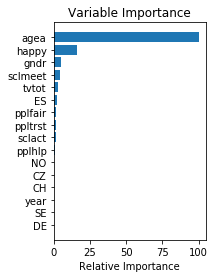

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

## Tuning parameters 
We'll use a grid search to tune the hyperparameters of the classifier. First, we'll tune the number of trees, shrinkage (learning rate), and the max depth of each tree.

### Iteration 1

In [5]:
# Trying different parameters all at once
param_test1 = [{'n_estimators':[40, 60, 80, 100], 
                'learning_rate':[0.001, 0.05, 0.1, 0.2],
               'max_depth':[2, 3, 4, 6, 8],
               }]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(min_samples_split=10,
                                                               min_samples_leaf=50,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10, 
                                                               loss='deviance'), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid=[{'n_estimators': [40, 60, 80, 100], 'learning_rate': [0.001, 0.05, 0.1, 0.2], 'max_depth': [2, 3, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [6]:
gsearch1.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 80}

In [7]:
gsearch1.best_score_

0.7873429280570626

A grid search explores the trade-off between different parameters to determine the best score of 78% accuracy by setting learning rate as 0.05, max depth as 6, and n estimators as 80. 

Let's fit a model with those parameters and see how it fares in cross-validation on the tuning dataset.

In [8]:
clf1 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=10,
                                           min_samples_leaf=50,
                                           n_estimators=80,
                                           max_depth=6,
                                           max_features='sqrt',
                                           subsample=0.8,
                                           random_state=10,
                                           loss='deviance')

clf1.fit(X_train,y_train)
predict_train = clf1.predict(X_train)

print(cross_val_score(clf1, X_train, y_train, cv=5))
print(cross_val_score(clf1, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[0.77096115 0.72528971 0.76687117 0.7366985  0.75836177]
0.7516364583570287
              precision    recall  f1-score   support

         0.0       0.75      0.94      0.84      4508
         1.0       0.84      0.51      0.64      2824

   micro avg       0.77      0.77      0.77      7332
   macro avg       0.80      0.73      0.74      7332
weighted avg       0.79      0.77      0.76      7332

Training set accuracy:
Percent Type I errors: 0.03696126568466994
Percent Type II errors: 0.1880796508456083




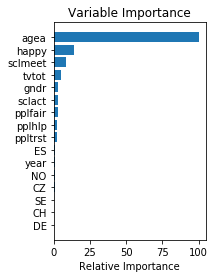

In [9]:
feature_importance = clf1.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

With 5 cross folds, we have an accuracy rating of around 75% in the training data. Type I error rates for the training data has dropped by 3% from the untuned model. Age remains disproportionately important in the model.

### Iteration 2

Let's try some of the parameters related to the estimators and see if we can improve the model.

In [10]:
#Start with smaller number 
param_test2 = [{'min_samples_split':[10, 50, 100, 200, 400], 
                'min_samples_leaf':[10,20,50,100,200],
               'subsample':[0.7, 0.8, 0.9], 
                'max_features':['sqrt','log2']}]
clf = ensemble.GradientBoostingClassifier(**params)
gsearch2 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                                        n_estimators=80,
                                                                        max_depth=6,
                                                                        random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch2.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samp...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid=[{'min_samples_split': [10, 50, 100, 200, 400], 'min_samples_leaf': [10, 20, 50, 100, 200], 'subsample': [0.7, 0.8, 0.9], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
gsearch2.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'min_samples_split': 200,
 'subsample': 0.7}

In [12]:
gsearch2.best_score_

0.7878858101444545

We'll adjust the next model according to the best parameters recommended and see if we can reach around 78% accuracy. 

For a final tuning procedure, we'll run the model with the exponential loss function in place of deviance.

In [13]:
clf2 = ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                           min_samples_split=200,
                                           min_samples_leaf=20,
                                           n_estimators=80,
                                           max_depth=6,
                                           max_features='sqrt',
                                           subsample=0.7,
                                           random_state=10,
                                           loss='deviance')

clf2.fit(X_train,y_train)
predict_train = clf2.predict(X_train)

print(cross_val_score(clf2, X_train, y_train, cv=5))
print(cross_val_score(clf2, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[0.73892297 0.66189502 0.76209952 0.73942701 0.75426621]
0.7313221485256287
              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84      4508
         1.0       0.84      0.52      0.64      2824

   micro avg       0.78      0.78      0.78      7332
   macro avg       0.80      0.73      0.74      7332
weighted avg       0.79      0.78      0.76      7332

Training set accuracy:
Percent Type I errors: 0.03696126568466994
Percent Type II errors: 0.18630660120021822




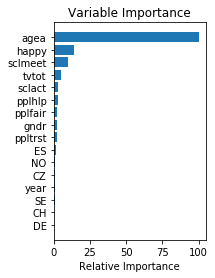

In [14]:
feature_importance = clf2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Here, Type I error rate remains the same, while the Type II error rate improves a bit. 

Let's run the model on our test data, to see how well it performs.

In [15]:
predict_test = clf2.predict(X_test)

#Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

              precision    recall  f1-score   support

         0.0       0.74      0.90      0.82       505
         1.0       0.76      0.49      0.59       310

   micro avg       0.75      0.75      0.75       815
   macro avg       0.75      0.70      0.70       815
weighted avg       0.75      0.75      0.73       815

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.19386503067484662




The tuned model performs a little better than the default model with respect to Type I errors, but it is a little worse with respect to Type II errors. Nevertheless, it is better protected from overfitting, so if we were to test it on additional unseen data, it might be more reliable.